In [1]:
import numpy as np
import re
import os
import torch
from FFT_PSF import compute_psf, torch_apply_psf
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt

f:\Anaconda\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def extract_psf_matrix(file_path):
    """
    从PSF.txt文件中提取点扩散函数(PSF)矩阵
    
    参数:
        file_path: PSF.txt文件路径
        
    返回:
        psf_matrix: 提取的PSF矩阵(numpy数组)
    """
    # 读取文件内容
    with open(file_path, 'rb') as f:
        # 以二进制读取并尝试解码，忽略错误字符
        content = f.read().decode('utf-8', errors='ignore')
    
    # 使用正则表达式提取数值行（包含科学计数法和普通小数）
    # 匹配包含多个数字（可能带有E±表示的科学计数法）的行
    pattern = r'(\d\.\d+E\-0\d)'
    matches = re.findall(pattern, content)


In [7]:
file_path="PSF.txt"
with open(file_path,'r',encoding='utf-16') as f:
    content=f.read()

# 使用正则表达式提取数值行（包含科学计数法和普通小数）
# 匹配包含多个数字（可能带有E±表示的科学计数法）的行
pattern = r'(\d\.\d+E\-0\d)'
# pattern = r'[+-]?\d+\.?\d*[Ee][+-]?\d+'
# matches中包含着
matches = re.findall(pattern=pattern,string=content)

print(float(matches[0]))

PSF_list=[float(s) for s in matches]

num_out=256
original_size=num_out

psf_matrix=np.array(PSF_list).reshape(num_out,num_out)


target_size=(101,101)
# 裁剪中间 101×101 区域
target_h, target_w = target_size
if target_h % 2 == 0 or target_w % 2 == 0:
    raise ValueError("Target size must be odd for centered cropping (e.g., 101×101)")

start_h = (original_size - target_h) // 2  # 起始高度：(256 - 101) // 2 = 77
start_w = (original_size - target_w) // 2  # 起始宽度：(256 - 101) // 2 = 77
psf_cropped = psf_matrix[start_h:start_h + target_h, start_w:start_w + target_w]


2.1129e-05


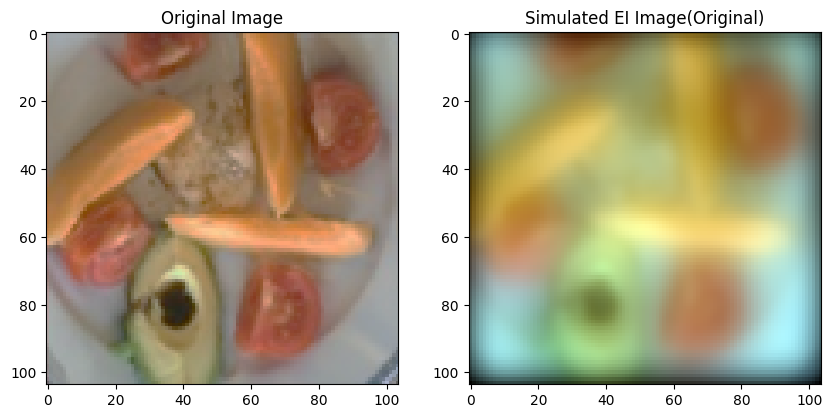

In [10]:
# 路径加载，模型路径等
model_path = ".\\best_pre_correction_models\\final_model_20251019_195055.pth"  # 或 "best_pre_correction_model.pth"
model_path_1 = "best_pre_correction_model.pth"
test_image_path="E:\\桌面\\微信图片_20251019131600_122_386.png"
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
if os.path.exists(test_image_path):
    test_img=Image.open(test_image_path).convert('RGB').resize((104,104))
    test_array=np.array(test_img).astype(np.float32)/255.0
else:
    raise FileNotFoundError(f"Test image not found at {test_image_path}")
# 测试的原图片
test_tensor=torch.from_numpy(test_array.transpose(2,0,1)).unsqueeze(0).to(device)
# 测试的原图片转为Pytorch向量
simulated_test_image=torch_apply_psf(psf_cropped,test_tensor)

# 对模拟成像的simulated_test_image进行处理，使其可以完成可视化
# 修正维度不匹配
if simulated_test_image.dim() == 3:  # 如果丢失批量维度，添加回去
    simulated_test_image = simulated_test_image.unsqueeze(0)
elif simulated_test_image.dim() != 4:  # 确保是 4 维张量
    raise ValueError(f"Unexpected dimension of simulated_test: {simulated_test_image.shape}")

# loss=criterion(simulated_test_image,test_tensor)

# 转simulated_test_image(tensor)为numpy数组
if simulated_test_image.dim()==4: # [B,C,H,W]
    simulated_test_image=simulated_test_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
else:
    raise ValueError(f"Unexpected dimension of simulated_test after unsqueeze: {simulated_test_image.shape}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(test_array)
plt.subplot(1,2,2)
plt.title("Simulated EI Image(Original)")
plt.imshow(simulated_test_image)
